generate conf
how to launch: python3 run_oblivious_c2s.py --conf computerouting2/cluster_c.conf --worker 1 --maxGB 5 --waitSec 30

In [3]:
trafficname = "cluster_c"
scaledown = 100000
with open(f"/home/annzhou/DRing/src/emp/datacentre/computerouting2/{trafficname}.conf",'w') as f:
    for H in range(1,25):
        f.write(f"python3 computerouting2/testtemporalH_meta.py {trafficname} {scaledown} {H}\n")

python3 run_oblivious_c2s.py --conf computerouting2/unv1.conf --worker 1 --maxGB 5 --waitSec 30

In [6]:
trafficname = "unv1"
scaledown = 10000000
with open(f"/home/annzhou/DRing/src/emp/datacentre/computerouting2/{trafficname}.conf",'w') as f:
    for H in range(1,5):
        f.write(f"python3 computerouting2/testtemporalH_wisc.py {trafficname} {scaledown} {H}\n")

calculate the best H

[0.09214835063409346, 0.09296500535011709, 0.09352326281361263, 0.09352326281361263]


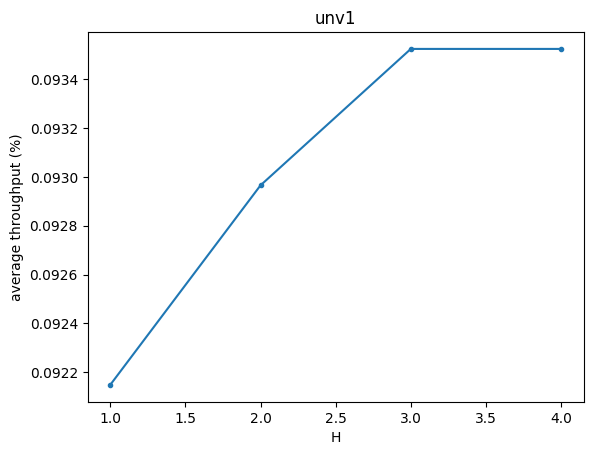

In [6]:
trafficname = "unv1"
numinterval = 8

resultfile = f"/home/annzhou/DRing/src/emp/datacentre/computerouting2/resultfiles/result_dring_0_0_{trafficname}_2_0"
throughputlistdict = dict()
with open(resultfile,'r') as f:
    lines = f.readlines()
    for line in lines:
        tokens = line.split(',')
        H = int(tokens[0])
        throughput = float(tokens[2])
        if H not in throughputlistdict: throughputlistdict[H] = list()
        throughputlistdict[H].append(throughput)

throughputdict = dict()
for H,throughputlist in throughputlistdict.items():
    throughputdict[H] = sum(throughputlist)/len(throughputlist)


import matplotlib
import matplotlib.pyplot as plt

xlist = list()
ylist = list()
for H in range(1,numinterval//2+1):
    xlist.append(H)
    ylist.append(throughputdict[H])
print(ylist)
plt.plot(xlist,ylist,marker='.')
plt.title(trafficname)
plt.xlabel("H")
plt.ylabel("average throughput (%)")
plt.savefig(f"/home/annzhou/DRing/src/emp/datacentre/computerouting2/output/H_dring_0_0_{trafficname}_2_0.png", dpi=500)
plt.show()

generate qivarfiles

tar ivarfiles:
cd qivardiles
tar -zcvf routing_unv1_ivar.tar.gz ivar_dring_0_0_*_unv1_*_2_0

untar ivarfiles:
cd qivardiles
tar -zxvf routing_prv1_ivar.tar.gz

In [9]:
# quantize
# copy from makepathweightfiles/makepathweightfiles.ipynb
import random
random.seed(0)

def quantize_to_multiple_of_1_64(x,factor):
    return round(x * factor) / factor

def quantize_and_adjust_with_indices(indexed_values,factor,isprint=False):
    if isprint: print(indexed_values)
    # Quantize each value
    quantized_values = [(i, quantize_to_multiple_of_1_64(v,factor)) for i, v in indexed_values]
    if isprint: print(quantized_values)
    
    # Calculate the current sum
    current_sum = sum(v for _, v in quantized_values)
    
    # Calculate the difference between the sum and 1
    difference = current_sum - 1
    if isprint: print(f"currsum={current_sum}, difference={difference}")

    random_values = [(v, random.random()) for v in quantized_values]
    if isprint: print(random_values)
    
    if difference != 0:
        if difference > 0:
            # Sort indices by quantized values to adjust the largest values first
            sorted_random = sorted(random_values, key=lambda x: (x[0][1],x[1]), reverse=True)
            # sorted_quantized = sorted(quantized_values, key=lambda x: x[1], reverse=True)
            sorted_quantized = [v for v,_ in sorted_random]
            if isprint: print(sorted_random)
            if isprint: print(sorted_quantized)
            
            while difference !=0:
                for i, value in sorted_quantized:
                    if difference == 0:
                        break
                    # Calculate adjustment
                    # adjustment = min(difference, value % (1 / factor))
                    # adjustment = difference
                    new_value = value - 1.0/factor
                    
                    # Update the quantized values
                    quantized_values = [(idx, new_value if idx == i else v) for idx, v in quantized_values]
                    difference -= 1.0/factor
                
        else:
            # If the difference is negative (i.e., sum is less than 1), we need to increase values
            sorted_quantized = sorted(quantized_values, key=lambda x: x[1])
            
            while difference != 0:
                for i, value in sorted_quantized:
                    if difference == 0:
                        break
                    # Calculate adjustment
                    # adjustment = min(-difference, (1 / factor) - (value % (1 / factor)))
                    # adjustment = -difference
                    new_value = value + 1.0/factor
                    
                    # Update the quantized values
                    quantized_values = [(idx, new_value if idx == i else v) for idx, v in quantized_values]
                    difference += 1.0/factor
    
    # Return the list sorted by original indices
    # return [v for i, v in sorted(quantized_values)]
    if isprint: print(quantized_values)
    return quantized_values

def check(qvarfile, numsw):
    # check qvarfile
    checkweightarr = list()
    for i in range(numsw):
        checkweightarr.append(list())
        for j in range(numsw):
            checkweightarr[i].append(0)
    with open(qvarfile,'r') as f:
        lines = f.readlines()
        for line in lines:
            tokens = line.split(',')
            fromsw = int(tokens[0])
            tosw = int(tokens[1])
            pid = int(tokens[2])
            weight = float(tokens[3])
            checkweightarr[fromsw][tosw] += weight

    for fromsw in range(numsw):
        for tosw in range(numsw):
            if checkweightarr[fromsw][tosw]!=0 and checkweightarr[fromsw][tosw]!=1:
                print(f"from {fromsw} to {tosw}: weight={checkweightarr[fromsw][tosw]}")

def quantize(varfile, qvarfile, factor, numsw):
    with open(varfile,'r') as f:
        lines = f.readlines()[1:]

    valuearr = list()
    weightarr = list()
    qweightarr = list()
    for i in range(numsw):
        valuearr.append(list())
        weightarr.append(list())
        qweightarr.append(list())
        for j in range(numsw):
            valuearr[i].append(list())
            weightarr[i].append(list())
            qweightarr[i].append(list()) 

    for line in lines:
        tokens = line.split(',')
        varname = tokens[0]
        vartokens = varname.split('_')
        fromsw = int(vartokens[0])
        tosw = int(vartokens[1])
        pid = int(vartokens[2])
        value = float(tokens[1])
        valuearr[fromsw][tosw].append([pid,value])
        weightarr[fromsw][tosw].append([pid,value])

    for fromsw in range(numsw):
        for tosw in range(numsw):
            if len(valuearr[fromsw][tosw])>0:
                valuesum = 0
                for _,value in valuearr[fromsw][tosw]:
                    valuesum += value
                valuetoweight = 1.0/valuesum
                for ipv,pv in enumerate(weightarr[fromsw][tosw]):
                    weightarr[fromsw][tosw][ipv][1] = pv[1] * valuetoweight

    for fromsw in range(numsw):
        for tosw in range(numsw):
            if len(weightarr[fromsw][tosw])>0:
                qweightarr[fromsw][tosw] = quantize_and_adjust_with_indices(weightarr[fromsw][tosw],factor)

    with open(qvarfile,'w') as f:
        for fromsw in range(numsw):
            for tosw in range(numsw):
                if len(qweightarr[fromsw][tosw])>0:
                    for pid,weight in qweightarr[fromsw][tosw]:
                        if weight>0:
                            f.write(f"{fromsw},{tosw},{pid},{weight}\n")

    check(qvarfile, numsw)

In [10]:
trafficname = "unv1"
H = 3
numinterval = 8
factor = 64
numsw = 80

resultfile = f"/home/annzhou/DRing/src/emp/datacentre/computerouting2/resultfiles/result_dring_0_0_{trafficname}_2_0"
with open(resultfile,'r') as f:
    lines = f.readlines()
    for line in lines:
        tokens = line.split(',')
        myH = int(tokens[0])
        if myH == H:
            solveinterval = int(tokens[1])
            routing = tokens[3]
            computeinterval = int(tokens[4])

            copyfromivarfile = f"/home/annzhou/DRing/src/emp/datacentre/qivarfiles/ivar_dring_0_0_{routing}_{trafficname}_{computeinterval}_2_0"
            copyintoqivarfile = f"/home/annzhou/DRing/src/emp/datacentre/qivarfiles/qivar_dring_0_0_{trafficname}_{solveinterval}_{routing}_2_0"

            quantize(copyfromivarfile,copyintoqivarfile,factor,numsw)

calculate total bytes in the trafficifle

In [11]:
trafficname = "unv1"

totalbytes = 0
with open(f"/home/annzhou/DRing/src/emp/datacentre/trafficfiles/{trafficname}",'r') as f:
    lines = f.readlines()
    for line in lines:
        tokens = line.split(',')
        totalbytes += int(tokens[3])
print(totalbytes)

162036861000
